In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [10]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([r, theta])

def pol2cart(r, theta, offset=0):
    x = r * np.cos(theta + offset)
    y = r * np.sin(theta + offset)
    return np.array([x, y])

def spring_force(A, B, mag):
    vec = np.subtract(B, A)
    return mag * vec / np.linalg.norm(vec) 


In [11]:
intake_pivot_end_pt = np.array([1.25, -3.45]) # in (x, y)
roller_diam = 1.2 # in
spring_mnt_pt = np.array([4.285, 0.613]) #in (x, y)
spring_force_mag_i = 10 # lb
spring_force_r = 0.915 # in
spring_length_i = 4.55 # in
k_factor = 0 # lb / in
degree_2x4 = 13.15 # deg
degree_4x4 = 53.04 # deg

In [12]:
def calc_system_force(intake_angle, force='vertical'):

    intake_angle_builtin = np.abs(np.arctan(intake_pivot_end_pt[0]/intake_pivot_end_pt[1]))
    intake_pivot_end_mag = np.linalg.norm(intake_pivot_end_pt)

    wood_contact_pt = pol2cart(intake_pivot_end_mag, 
                                intake_angle + intake_angle_builtin, 
                                offset=np.deg2rad(-90))

    if force == 'vertical':
        wood_contact_pt = np.add(wood_contact_pt, np.array([0, -roller_diam / 2]))
    else:
        wood_contact_pt = np.add(wood_contact_pt, np.array([-roller_diam / 2, 0]))

    spring_force_pt = np.array(pol2cart(spring_force_r, intake_angle, offset=np.deg2rad(-90)))

    spring_length = np.linalg.norm(np.subtract(spring_force_pt, spring_mnt_pt))
    spring_compressed_dist = spring_length_i - spring_length

    spring_force_mag = spring_compressed_dist * k_factor + spring_force_mag_i

    spring_force_vec = spring_force(spring_mnt_pt, spring_force_pt, spring_force_mag)

    if force == 'vertical':
        wood_normal_moment = np.cross(wood_contact_pt, np.array([0, 1]))
    else:
        wood_normal_moment = np.cross(wood_contact_pt, np.array([1, 0]))

    system_mat_A = np.array([[1, 0, 0],
                            [0, 1, 1], 
                            [0, 0, wood_normal_moment]])

    system_mat_B = np.array([[-spring_force_vec[0]],
                            [-spring_force_vec[1]],
                            [-np.cross(spring_force_pt, spring_force_vec)]])

    A_x, A_y, wood_normal_force = np.linalg.solve(system_mat_A, system_mat_B)
    return wood_normal_force[0] * 2 # two springs on each intake

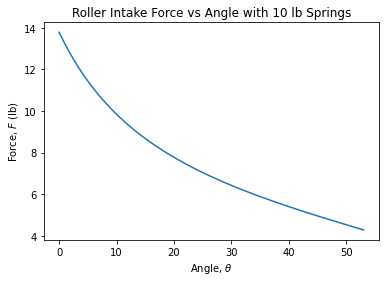

In [13]:
intake_angles = np.linspace(0, 53, 100)
normal_forces = []
for a in intake_angles:
    normal_forces.append(calc_system_force(np.deg2rad(a)))

fig_1, ax_1 = plt.subplots(figsize=(6,4))
ax_1.plot(intake_angles, normal_forces)
ax_1.set_ylabel(r"Force, $F$ (lb)")
ax_1.set_xlabel(r"Angle, $\theta$")
ax_1.set_title(f"Roller Intake Force vs Angle with {spring_force_mag_i} lb Springs")
fig_1.show()

In [14]:
angle_2x4 = np.deg2rad(degree_2x4)
angle_4x4 = np.deg2rad(degree_4x4)
print(f"clamping force with 2x4 or 2x6 = {calc_system_force(angle_2x4):g}")
print(f"clamping force with 4x4 = {calc_system_force(angle_4x4):g}")

clamping force with 2x4 or 2x6 = 9.07031
clamping force with 4x4 = 4.27717


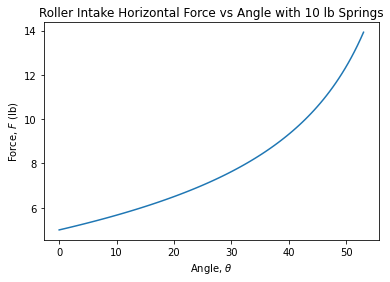

In [15]:
horizontal_forces = []
for a in intake_angles:
    horizontal_forces.append(calc_system_force(np.deg2rad(a), force='horizontal'))

fig_2, ax_2 = plt.subplots(figsize=(6,4))
ax_2.plot(intake_angles, horizontal_forces)
ax_2.set_ylabel(r"Force, $F$ (lb)")
ax_2.set_xlabel(r"Angle, $\theta$")
ax_2.set_title(f"Roller Intake Horizontal Force vs Angle with {spring_force_mag_i} lb Springs")
fig_2.show()

In [16]:
print(f"initial horizontal force = {horizontal_forces[0]:g}")

initial horizontal force = 4.9962
